### Panel app to show colormap artifacts 

#### How to Use the App
1. **Run all cells**: Click **Run → Run All Cells** from the menu (or press `Shift+Enter` repeatedly)
2. **Scroll to the bottom**: The interactive app will appear at the end of the notebook
3. **Use the dropdowns**: Select different colormap collections and colormaps to compare
4. **Watch the plots update**: See how different colormaps affect perception and edge detection

#### Objective of the notebook
Building and deployment of a working app ... pain-free 

#### Do it yourself
Tutorial: [Panel: Dashboards for PyData](https://youtu.be/AXpjbJUVeb4), presented by James Bednar

Getting started guide: https://panel.holoviz.org/getting_started/index.html

#### License

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"> CC BY Creative Commons License</a>, with the exception of the data used (a horizon surface from the [Penobscot 3D](https://terranubis.com/datainfo/Penobscot) which is covered by a [CC BY-SA Creative Commons License](https://creativecommons.org/licenses/by-sa/3.0/)).

#### Preliminaries

In [1]:
import os
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cm
import colorcet
import cmocean
import cmcrameri.cm as cmc
from skimage import io, color, exposure

In [2]:
from matplotlib import rc
font = {'size'   : 22}
rc('font', **font)

In [3]:
plt.switch_backend('agg')

In [4]:
import param
import panel as pn
pn.extension()

#### Helper functions

In [5]:
def normalise(data):
    """
    Normalize an array to [0-1] range
    """
    data_n = (data-np.amin(data)) / (np.amax(data)-np.amin(data))
    return data_n 

def Sobel_2d(data):
    """
    Calculate 2D Sobel edges
    """
    dx = ndi.sobel(data, 0)  # horizontal derivative
    dy = ndi.sobel(data, 1)  # vertical derivative
    mag = np.hypot(dx, dy)      # magnitude
    mag *= 255.0 / np.max(mag)  # normalize
    return mag 

In [6]:
def mk_cmapped_data(data, mpl_cmap_name):
    """
    This function makes a figure (but does not display it),
    plots the data with a colormap, then saves the 
    colormapped data from the canvas to a numpy array
     
    Updated after: https://stackoverflow.com/a/62518311/1034648
    """
    # Use `LinearSegementedColormap` and `Normalize` instances directly
    cmap = plt.get_cmap(mpl_cmap_name)
    norm = plt.Normalize(data.min(), data.max())

    # The norm instance scales data to a 0-1 range, cmap makes it RGB
    mat = cmap(norm(data))  

    # MPL uses a 0-1 float RGB representation, so scale to 0-255
    mat = (255 * mat).astype(np.uint8) 
    return mat

#### Make custom Blues colormap (with the darkest blue taken out) for the intensity plots

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    function to truncate a matplotlib colormap
    from: https://stackoverflow.com/a/18926541/1034648
    """
    new_cmap = clr.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
cmap = plt.get_cmap('Blues_r')
Blues_r_t = truncate_colormap(cmap, 0.0, 0.8)

#### Load and register my colormaps 

For background check on my blog [here](https://mycarta.wordpress.com/color-palettes/).

With thanks to [@aadm](https://github.com/aadm): the logic for registering the colormaps in a loop is adapted from [this notebook of his](https://github.com/aadm/geophysical_notes/blob/master/colormaps.ipynb) !

In [9]:
data_folder = 'data'

In [10]:
names_and_files = {'matteo_cube': 'data/cube1_0-1.csv', 
                   'matteo_cubeYF': 'data/cubeYF_0-1.csv', 
                   'matteo_linear_L': 'data/Linear_L_0-1.csv'}

for n, f in names_and_files.items():
    tmp = clr.ListedColormap(np.loadtxt(f, delimiter=','), name=n)
    tmp_r = clr.ListedColormap(np.flipud(np.loadtxt(f, delimiter=',')), name=n+'_r')
    # Use force=True to allow re-registration (useful when re-running cells)
    plt.colormaps.register(cmap=tmp, name=n, force=True)
    plt.colormaps.register(cmap=tmp_r, name=n+'_r', force=True)

#### Load the seismic horizon(from the [Penobscot 3D](https://terranubis.com/datainfo/Penobscot)) and normalise to [0 1] range

In [11]:
horiz_file = os.path.join(data_folder,'Penobscot_HorB.npy')
data = normalise(np.load(horiz_file)[55:-55,25:-25])

#### Text widget to explain (briefly at the moment) the purpose of the app

In [12]:
explain_text = 'A simple app to demonstrate the effect of colormaps on perception and on the ability \
to see fault traces as edges on a seismic horizon.'

In [13]:
explain_widget = pn.widgets.StaticText(name='Check perception effects', value= explain_text, width = 1000, styles={'font-size': '20px'})

#### Text widget with instructions

In [14]:
select_text_1 = '(1) Look at the top row plots'
select_text_2 = '(2) select a cmap with the two drop-down menus'
select_text_3 = '(3) see the effect of cmap on bottom row plots'

In [15]:
text_widget = pn.Row(
    pn.pane.HTML(f'<span style="font-size: 20px; font-weight: bold;">{select_text_1}</span>'),
    pn.pane.HTML(f'<span style="font-size: 20px; font-weight: bold;">{select_text_2}</span>'),
    pn.pane.HTML(f'<span style="font-size: 20px; font-weight: bold;">{select_text_3}</span>'),
    width=1000
)

In [16]:
text_widget

Row(width=1000)
    [0] HTML(str)
    [1] HTML(str)
    [2] HTML(str)

#### Function to show the reference plots in grayscale
Performs all the plotting tasks, including calls to the helper functions to create required variables

In [17]:
def make_original_plots(dt):
    """
    This function makes the reference plots, which will be the bottom ones in the app.
    It makes static displays of:
    1) On the left, the seismic data plotted with gray scale colormap
    2) In the middle, the gray scale intensity of the data
    3) On the right, the contrast-enhanced Sobel edges of the intensity
    """
    I = dt  # dt is already grayscale normalized data
    Sob = Sobel_2d(I) 
    fig = plt.figure(figsize = (12,3))   
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(dt, cmap='gray', aspect = 'auto',  interpolation = 'none')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title(' Horizon, grayscale', fontsize=16)       
    ax3 = fig.add_subplot(1, 3, 2)
    ax3.imshow(I, cmap=Blues_r_t, aspect = 'auto', interpolation = 'none')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('intensity', fontsize=16)       
    ax5 = fig.add_subplot(1, 3, 3)
    ax5.imshow(Sob, cmap='gray_r', vmax = 70, aspect = 'auto', interpolation = 'none')
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax5.set_title('Sobel edges', fontsize=16)
    plt.tight_layout()                                    
    plt.close(fig=fig)   
    return fig

#### Class to make colormapped plots

This class links two parameters, one for the collection (either Matplotlib colormaps or Colorcet colormaps) and one for the colormap, so that when the collection is changed, only valid colormaps are allowed.

The link between the two parameters (collection and colormap) is achieved using the first `param.depends` decorator.

With the second `param.depends` decorator, when the colormap  is changed the plots are updated with the `make_cmapped_plots` method


In [18]:
# Define colormap lists
matplotlib_cmaps = sorted([
    'viridis', 'plasma', 'inferno', 'magma', 'cividis',
    'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
    'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
    'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn',
    'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
    'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
    'hot', 'afmhot', 'gist_heat', 'copper', 
    'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
    'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
    'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
    'gnuplot', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 
    'rainbow', 'jet', 'nipy_spectral', 'gist_ncar',
    'viridis_r', 'plasma_r', 'inferno_r', 'magma_r', 'cividis_r',
    'Greys_r', 'Purples_r', 'Blues_r', 'Greens_r', 'Oranges_r', 'Reds_r',
    'YlOrBr_r', 'YlOrRd_r', 'OrRd_r', 'PuRd_r', 'RdPu_r', 'BuPu_r',
    'GnBu_r', 'PuBu_r', 'YlGnBu_r', 'PuBuGn_r', 'BuGn_r', 'YlGn_r',
    'binary_r', 'gist_yarg_r', 'gist_gray_r', 'gray_r', 'bone_r', 'pink_r',
    'spring_r', 'summer_r', 'autumn_r', 'winter_r', 'cool_r', 'Wistia_r',
    'hot_r', 'afmhot_r', 'gist_heat_r', 'copper_r', 
    'PiYG_r', 'PRGn_r', 'BrBG_r', 'PuOr_r', 'RdGy_r', 'RdBu_r',
    'RdYlBu_r', 'RdYlGn_r', 'Spectral_r', 'coolwarm_r', 'bwr_r', 'seismic_r',
    'flag_r', 'prism_r', 'ocean_r', 'gist_earth_r', 'terrain_r', 'gist_stern_r',
    'gnuplot_r', 'CMRmap_r', 'cubehelix_r', 'brg_r', 'gist_rainbow_r', 
    'rainbow_r', 'jet_r', 'nipy_spectral_r', 'gist_ncar_r'], key=str.casefold)

colorcet_cmaps = sorted([
    'cet_bgy', 'cet_bkr', 'cet_bgyw', 'cet_bky', 'cet_kbc', 'cet_coolwarm', 
    'cet_blues', 'cet_gwv', 'cet_bmw', 'cet_bjy', 'cet_bmy', 'cet_bwy', 'cet_kgy', 
    'cet_cwr', 'cet_gray', 'cet_dimgray', 'cet_fire', 'cet_kg', 'cet_kr',
    'cet_colorwheel', 'cet_isolum', 'cet_rainbow', 'cet_bgy_r', 'cet_bkr_r', 
    'cet_bgyw_r', 'cet_bky_r', 'cet_kbc_r', 'cet_coolwarm_r', 'cet_blues_r', 
    'cet_gwv_r', 'cet_bmw_r', 'cet_bjy_r', 'cet_bmy_r', 'cet_bwy_r', 'cet_kgy_r', 
    'cet_cwr_r', 'cet_gray_r', 'cet_dimgray_r', 'cet_fire_r', 'cet_kg_r', 
    'cet_kr_r', 'cet_colorwheel_r', 'cet_isolum_r', 'cet_rainbow_r'])

mycarta_cmaps = sorted(['matteo_cube', 'matteo_cubeYF', 'matteo_linear_L',
                         'matteo_cube_r', 'matteo_cubeYF_r', 'matteo_linear_L_r'])

# Crameri Scientific Colormaps (https://www.fabiocrameri.ch/colourmaps/)
crameri_cmaps = sorted([
    'cmc.acton', 'cmc.acton_r', 'cmc.bam', 'cmc.bam_r', 'cmc.bamako', 'cmc.bamako_r',
    'cmc.batlow', 'cmc.batlow_r', 'cmc.batlowK', 'cmc.batlowK_r', 'cmc.batlowW', 'cmc.batlowW_r',
    'cmc.berlin', 'cmc.berlin_r', 'cmc.bilbao', 'cmc.bilbao_r', 'cmc.broc', 'cmc.broc_r',
    'cmc.buda', 'cmc.buda_r', 'cmc.bukavu', 'cmc.bukavu_r', 'cmc.cork', 'cmc.cork_r',
    'cmc.davos', 'cmc.davos_r', 'cmc.devon', 'cmc.devon_r', 'cmc.fes', 'cmc.fes_r',
    'cmc.glasgow', 'cmc.glasgow_r', 'cmc.grayC', 'cmc.grayC_r', 'cmc.hawaii', 'cmc.hawaii_r',
    'cmc.imola', 'cmc.imola_r', 'cmc.lajolla', 'cmc.lajolla_r', 'cmc.lapaz', 'cmc.lapaz_r',
    'cmc.lipari', 'cmc.lipari_r', 'cmc.lisbon', 'cmc.lisbon_r', 'cmc.managua', 'cmc.managua_r',
    'cmc.navia', 'cmc.navia_r', 'cmc.nuuk', 'cmc.nuuk_r', 'cmc.oleron', 'cmc.oleron_r',
    'cmc.oslo', 'cmc.oslo_r', 'cmc.roma', 'cmc.roma_r', 'cmc.tofino', 'cmc.tofino_r',
    'cmc.tokyo', 'cmc.tokyo_r', 'cmc.turku', 'cmc.turku_r', 'cmc.vanimo', 'cmc.vanimo_r',
    'cmc.vik', 'cmc.vik_r'])

# cmocean colormaps (https://matplotlib.org/cmocean/)
cmocean_cmaps = sorted([
    'cmo.algae', 'cmo.algae_r', 'cmo.amp', 'cmo.amp_r', 'cmo.balance', 'cmo.balance_r',
    'cmo.curl', 'cmo.curl_r', 'cmo.deep', 'cmo.deep_r', 'cmo.delta', 'cmo.delta_r',
    'cmo.dense', 'cmo.dense_r', 'cmo.diff', 'cmo.diff_r', 'cmo.gray', 'cmo.gray_r',
    'cmo.haline', 'cmo.haline_r', 'cmo.ice', 'cmo.ice_r', 'cmo.matter', 'cmo.matter_r',
    'cmo.oxy', 'cmo.oxy_r', 'cmo.phase', 'cmo.phase_r', 'cmo.rain', 'cmo.rain_r',
    'cmo.solar', 'cmo.solar_r', 'cmo.speed', 'cmo.speed_r', 'cmo.tarn', 'cmo.tarn_r',
    'cmo.tempo', 'cmo.tempo_r', 'cmo.thermal', 'cmo.thermal_r', 'cmo.topo', 'cmo.topo_r',
    'cmo.turbid', 'cmo.turbid_r'])

colormaps_dict = {
    'matplotlib': matplotlib_cmaps,
    'colorcet': colorcet_cmaps,
    'mycarta': mycarta_cmaps,
    'crameri': crameri_cmaps,
    'cmocean': cmocean_cmaps
}

# Create explicit widgets
collection_widget = pn.widgets.Select(name='Collection', options=['matplotlib', 'colorcet', 'mycarta', 'crameri', 'cmocean'], value='matplotlib')
colormap_widget = pn.widgets.Select(name='Colormap', options=matplotlib_cmaps, value='cubehelix')

# Callback to update colormap options when collection changes
def update_colormap_options(event):
    new_collection = event.new
    new_options = colormaps_dict[new_collection]
    colormap_widget.options = new_options
    colormap_widget.value = new_options[0]

collection_widget.param.watch(update_colormap_options, 'value')

# Reactive plotting function
@pn.depends(colormap_widget)
def make_cmapped_plots(selected_colormap):
    """
    This function makes the reactive plots, the bottom ones in the app:
    1) On the left, the colormapped data plotted with the user selected colormap
    2) In the middle, the gray scale intensity of the colormapped data
    3) On the right, the contrast-enhanced Sobel edges of the intensity
    """
    # Handle different colormap sources
    if selected_colormap.startswith('cmc.'):
        cmap_name = selected_colormap[4:]  # Remove 'cmc.' prefix
        cmap_obj = getattr(cmc, cmap_name)
    elif selected_colormap.startswith('cmo.'):
        cmap_name = selected_colormap[4:]  # Remove 'cmo.' prefix
        cmap_obj = getattr(cmocean.cm, cmap_name)
    else:
        cmap_obj = plt.get_cmap(selected_colormap)
    
    # Apply colormap to data
    norm = plt.Normalize(data.min(), data.max())
    mat = cmap_obj(norm(data))
    mat = (255 * mat).astype(np.uint8)
    
    # Handle both RGB (3 channels) and RGBA (4 channels) data
    if mat.shape[-1] == 4:  # RGBA
        I_cmapped = color.rgb2gray(mat[:,:,:3])
    else:  # RGB
        I_cmapped = color.rgb2gray(mat)
    Sob_cmapped = Sobel_2d(I_cmapped)
    
    fig = plt.figure(figsize=(12,3))  
    ax2 = fig.add_subplot(1, 3, 1)
    ax2.imshow(mat, aspect='auto', interpolation='none')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('Colormapped horizon', fontsize=16)  
    ax4 = fig.add_subplot(1, 3, 2)
    ax4.imshow(I_cmapped, cmap=Blues_r_t, aspect='auto', interpolation='none')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('Intensity', fontsize=16)  
    ax6 = fig.add_subplot(1, 3, 3)
    ax6.imshow(Sob_cmapped, cmap='gray_r', vmax=70, aspect='auto', interpolation='none')
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax6.set_title('Sobel edges', fontsize=16)
    plt.tight_layout()                                  
    plt.close(fig=fig)
    return fig

#### Compose the panels

In [19]:
ctool = pn.Column(
    explain_widget,
    text_widget,
    pn.Row(collection_widget, colormap_widget),
    make_original_plots(data),
    make_cmapped_plots
)

#### Serve the app

Column
    [0] StaticText(name='Check perception e..., styles={'font-size': '20px'}, value='A simple app t..., width=1000)
    [1] Row(width=1000)
        [0] HTML(str)
        [1] HTML(str)
        [2] HTML(str)
    [2] Row
        [0] Select(name='Collection', options=['matplotlib', ...], value='matplotlib')
        [1] Select(name='Colormap', options=['afmhot', 'afmhot_r', ...], value='cubehelix')
    [3] Matplotlib(Figure)
    [4] ParamFunction(function, _pane=Matplotlib, defer_load=False)
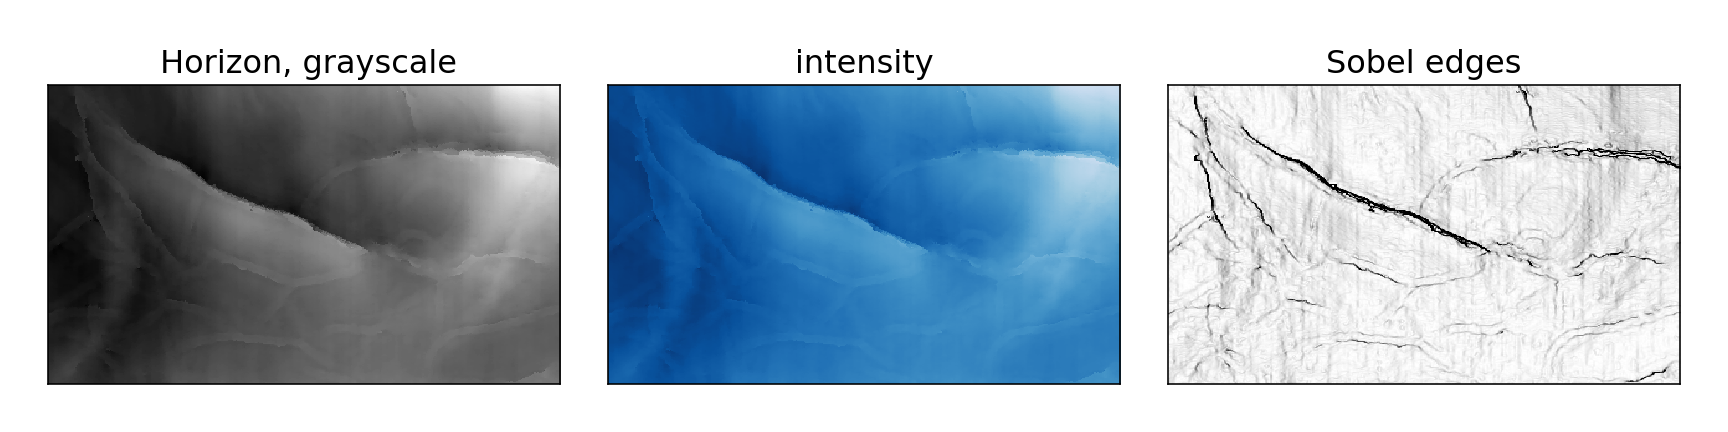
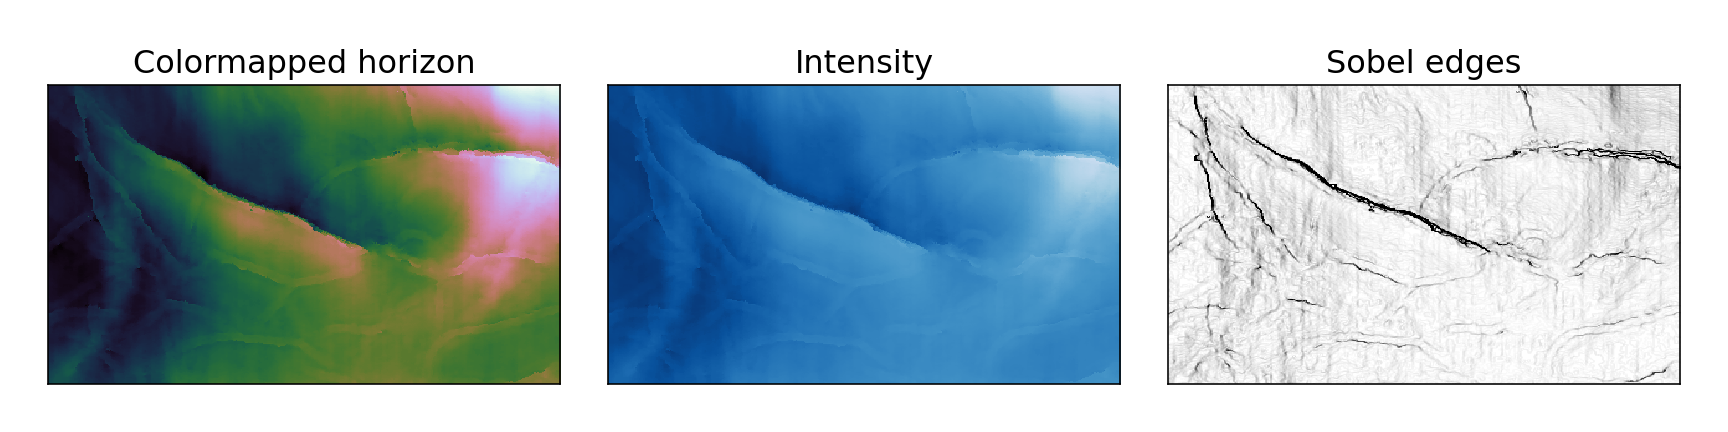

In [20]:
ctool.servable(); # for server deployment
ctool  # uncomment for immediate deployment from notebook

__To do next:__

- ~~ADD FABIO CRAMERI'S COLORMAP~~ ✅ Done
- ~~ADD CMOCEAN~~ ✅ Done
- BAD COLORMAP EQUALIZATION TOOL